## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('Data Analyst_project 2\\analyzeabtestresults-2\\AnalyzeABTestResults 2\\ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
(df.query('landing_page == "new_page" & group != "treatment"')['user_id'].count()) + (df.query('group == "treatment" & landing_page != "new_page"')['user_id'].count())

3893

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. We delete rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page** .  Store new dataframe in **df2**.

In [9]:
#find rows where new_page does not line up with treatment
rows1 = df.query('landing_page == "new_page" & group != "treatment"').index
#delete rows where new_page does not line up with treatment
df2 = df.drop(rows1, axis = 0)
#find rows where treatment does not line up with new_page
rows2 = df2.query('group == "treatment" & landing_page != "new_page"').index
#delete rows where treatment does not line up with new_page
df2 = df2.drop(rows2, axis = 0)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** to answer the questions below

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'], keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'], keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates(['user_id'])


`4.` Use **df2** to answer the following questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
conv_rate_new = df2.query('group == "control"')['converted'].mean()
conv_rate_new

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
conv_rate_old = df2.query('group == "treatment"')['converted'].mean()
conv_rate_old

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"')['user_id'].count()/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

Probability that user received the old page will be converted is 12.04 %, whereas probability that user received the new page will be converted is 11.88 %. Based on this evidence, we can say that using the old page probability of conversion is 0.16 % higher.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, I will consider I need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should my null and alternative hypotheses be?


$$H_0: p_{new} - p_{old} <= 0$$


$$H_1: p_{new} - p_{old} \ > 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
#under the null hypothesis p_new and p_old have equal conversion rate 
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
#under the null hypothesis p_new and p_old have equal conversion rate 
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
#number of rows for users received new page
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. What is $n_{old}$?

In [22]:
#number of rows for users received old page
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0,1],n_new, p=(1-p_new, p_new))
new_page_converted

array([0, 0, 1, ..., 0, 0, 1])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0,1],n_old, p=(1-p_new, p_new))
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

-0.0017295592870774923

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
#draw 10000 samples from binominal distribution
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [27]:
#Set up styles for the graphs globally
sb.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('font', size=1)    

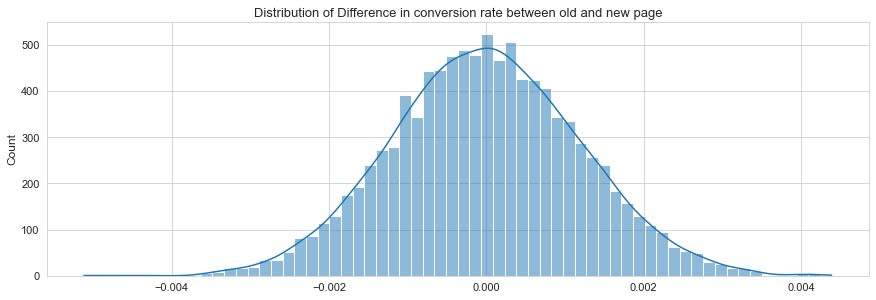

In [28]:
#plot the histogram of the p_diffs
plt.figure(figsize=(12,4), tight_layout=True)
sb.histplot(p_diffs, kde = True)
plt.title('Distribution of Difference in conversion rate between old and new page');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
#conversions for old page
convert_old = df2.query('group == "control" & converted == 1').shape[0]
#conversions for new page
convert_new = df2.query('group == "treatment" & converted == 1').shape[0]
#number of individuals who received old page
n_old = df2.query('group == "control"').shape[0]
#number of individuals who received new page
n_new = df2.query('group == "treatment"').shape[0]
#conversion rate for new page
conv_rate_new = convert_new/n_new
#conversion rate for old page
conv_rate_old = convert_old/n_old


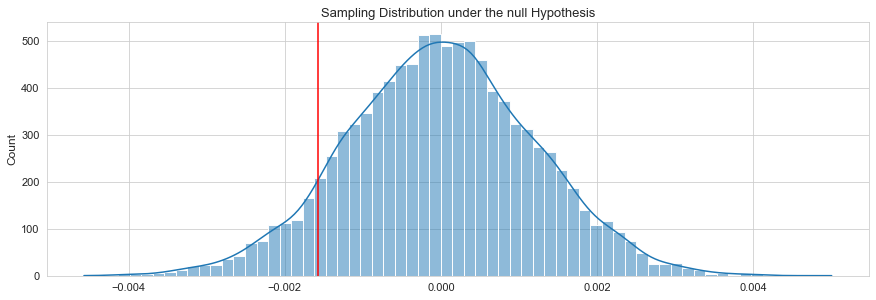

In [30]:
#difference in conversion rates from the actual data
obs_diff = conv_rate_new - conv_rate_old
#sampling distribution under null
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
#plot sampling distribution under null
plt.figure(figsize=(12,4), tight_layout=True)
sb.histplot(null_vals, kde = True)
plt.title('Sampling Distribution under the null Hypothesis');
#plot difference in conversion rates from the actual data
plt.axvline(x = obs_diff, color = 'r');

In [31]:
#calculate p value
pval = (null_vals > obs_diff).mean()
pval

0.9104

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Above I computed the probability of observing statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. This value is called p-value. Large p - value suggests that we shouldn't move away from the null hypothesis and vise versa. In our case p - value is 0.8986 which is close to 1. Based on this p - value, we fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
#import library
import statsmodels.api as sm
#display conversions for old page
print(convert_old)
#display conversions for new page
print(convert_new)
#display number of individuals who received old page
print(n_old)
#display number of individuals who received old page
print(n_new)

17489
17264
145274
145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
#import additional libraries
from statsmodels.stats.proportion import proportions_ztest
#storing conversions for old and new pages as numpy arrays
count = np.array([convert_new, convert_old])
#storing number of individuals who received old page and new page as numpy arrays
nobs = np.array([n_new, n_old])
#storing results of z test including p - values
stat, pval = proportions_ztest(count, nobs, alternative = 'larger')
pval


0.9050583127590245

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

As described above, proportions_ztest calculates test statistic for z test and p - value. Based on z test performed p value is equal to 0.9051 which supports findings described in part j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since our response should be bound between zero and one, we will use logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
#add dummy variables to dataframe
df2[['ab_page', 'other']] = pd.get_dummies(df2['landing_page'])
#since we are interested in full rank, let's drop the other column
df2 = df2.drop(['other'], axis = 1)
#add intercept
df2['intercept'] = 1

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [35]:
#import required library
import statsmodels.api as sm
#set up logistic regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
#fitting logistic regression model
results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
#display summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:               8.077e-06
Time:                        18:12:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

p-value associated with ab_page is 0.190.  
Under null hypothesis in logistic regression model it is assumed that there is no difference between new page and old page, whereas under alternative hypothesis it is assumed that there is a difference between new and old page.  
Under null hypothesis in Part II conversion with new page is lower or equal to conversion with old page, and under the alternative hypothesis conversion with new page is higher than conversion with old page. In other words the difference between p-values of Part 2 and 3 is because we have performed a one-tailed test in Part 2, and in Part 3, we are performing a two-tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

There may be lots of factors that would affect conversion. From those available to us in our dataset, timestamp may be useful.
If we  include other factors in the regression model, we might notice some relationships. For example, new site might have more conversion in the evening and old site may have more conversion in the morning. However, when a lot of additional terms are added to the regression model, some terms may some variable may correlated with one another. This may distruct the summary results of our regression model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [38]:
#read countries dataset
countries_df = pd.read_csv('Data Analyst_project 2\\analyzeabtestresults-2\\AnalyzeABTestResults 2\\countries.csv')
#join df_new and countries datasets
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
#reseting index
df_new = df_new.reset_index()


In [39]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
#display first five rows
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [40]:
# set up a regression model
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
# Fit a Linear Model And Obtain the Results
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:               2.323e-05
Time:                        18:13:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
#Create a column for interaction between ab_page and CA
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
#Create a column for interaction between ab_page and UK
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
#display first five rows
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,US_ab_page,UK_ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [42]:
# set up a regression model
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK', 'UK_ab_page', 'US_ab_page']])
# Fit a Linear Model And Obtain the Results
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:               3.482e-05
Time:                        18:13:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

Here we look at the way that variable country is related to conversions is dependent on the variable ab_page. Since p - value of UK_ab_page and CA_ab_page is large, we can say that interaction between variables is week and we should not include interaction variables in our model.

<a id='conclusions'></a>
## Conclusions
In conclusion, we tested our hypothesis from different angles and all approaches proved that p-value of all proposed variables is higher than Type I error rate of 5%. So we can say that we do not have enough evidence to reject the null hypothesis. In other words, we fail to reject the null hypothesis. Based on this, the new version of web page should not be implemented.